# Classical Baselines for QEvasion

This notebook implements classical machine learning baselines for both tasks:

## Task 1: Clarity Classification (3-way)
- Clear Reply
- Clear Non-Reply  
- Ambivalent

## Task 2: Evasion Classification (9-way)
- Explicit, Implicit, General, Deflection, Dodging
- Declining to answer, Claims ignorance, Clarification, Partial/half-answer

**Important**: Task 2 test set has multiple annotators - any match is correct.

## Baselines Implemented:
1. Majority class baseline
2. TF-IDF + Logistic Regression
3. TF-IDF + Linear SVM
4. TF-IDF + Random Forest (if time permits)

The goal is to benchmark very standard text classifiers on these tasks to establish reference baselines before trying more complex models

## 1. Setup

In [ ]:
import os
import sys
from pathlib import Path

# Add project root to path
project_root = Path(os.getcwd()).parent
sys.path.append(str(project_root))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

# Project imports
from src.data import (
    load_qevasion_prepared,
    prepare_task1_data,
    prepare_task2_data,
    CLARITY_LABELS,
    EVASION_LABELS,
    EVASION_TO_ID,
    ID_TO_EVASION
)
from src.metrics import (
    evaluate_task1,
    evaluate_task2_standard,
    evaluate_task2_multi_annotator,
    plot_confusion_matrix,
    majority_baseline_accuracy
)

# Plotting config
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (10, 6)

# Reproducibility
np.random.seed(42)

## 2. Load and Prepare Data

Data is loaded and split into train/validation/test, and a unified text representation (question + answer) is used as the input feature to the models

In [8]:
# Load dataset
dataset = load_qevasion_prepared()

print("Dataset loaded:")
print(dataset)

# Prepare Task 1 data
print("\nPreparing Task 1 (Clarity)...")
task1_train, task1_val, task1_test = prepare_task1_data(dataset)

print(f"Train: {len(task1_train)} | Val: {len(task1_val)} | Test: {len(task1_test)}")
print("\nClarity distribution (train):")
print(task1_train['clarity_label'].value_counts())

# Prepare Task 2 data
print("\n" + "="*60)
print("Preparing Task 2 (Evasion)...")
task2_train, task2_val, task2_test = prepare_task2_data(dataset)

print(f"Train: {len(task2_train)} | Val: {len(task2_val)} | Test: {len(task2_test)}")
print("\nEvasion distribution (train):")
print(task2_train['evasion_label'].value_counts())

Dataset loaded:
DatasetDict({
    train: Dataset({
        features: ['title', 'date', 'president', 'url', 'question_order', 'interview_question', 'interview_answer', 'gpt3.5_summary', 'gpt3.5_prediction', 'question', 'annotator_id', 'annotator1', 'annotator2', 'annotator3', 'inaudible', 'multiple_questions', 'affirmative_questions', 'index', 'clarity_label', 'evasion_label'],
        num_rows: 3448
    })
    test: Dataset({
        features: ['title', 'date', 'president', 'url', 'question_order', 'interview_question', 'interview_answer', 'gpt3.5_summary', 'gpt3.5_prediction', 'question', 'annotator_id', 'annotator1', 'annotator2', 'annotator3', 'inaudible', 'multiple_questions', 'affirmative_questions', 'index', 'clarity_label', 'evasion_label'],
        num_rows: 308
    })
})

Preparing Task 1 (Clarity)...
Train: 3103 | Val: 345 | Test: 308

Clarity distribution (train):
clarity_label
Ambivalent         1836
Clear Reply         947
Clear Non-Reply     320
Name: count, dtype: int64


## 3. Feature Extraction: TF-IDF

Here the unified text is transformed into TF–IDF vectors; labels are encoded as integers for multi-class classification

In [9]:
# Create TF-IDF vectorizer
tfidf = TfidfVectorizer(
    ngram_range=(1, 2),  # Unigrams + bigrams
    max_features=30000,
    min_df=2,           # Ignore terms appearing in < 2 documents
    max_df=0.95,        # Ignore terms appearing in > 95% of documents
    sublinear_tf=True   # Apply sublinear tf scaling
)

# Fit on Task 1 training data
print("Fitting TF-IDF on Task 1 training data...")
X_task1_train = tfidf.fit_transform(task1_train['text'])
X_task1_val = tfidf.transform(task1_val['text'])
X_task1_test = tfidf.transform(task1_test['text'])

print(f"Train shape: {X_task1_train.shape}")
print(f"Val shape: {X_task1_val.shape}")
print(f"Test shape: {X_task1_test.shape}")

# Transform Task 2 data with same vectorizer
X_task2_train = tfidf.transform(task2_train['text'])
X_task2_val = tfidf.transform(task2_val['text'])
X_task2_test = tfidf.transform(task2_test['text'])

print(f"\nTask 2 - Train shape: {X_task2_train.shape}")
print(f"Task 2 - Val shape: {X_task2_val.shape}")
print(f"Task 2 - Test shape: {X_task2_test.shape}")

# Get labels
y_task1_train = task1_train['clarity_id'].values
y_task1_val = task1_val['clarity_id'].values
y_task1_test = task1_test['clarity_id'].values

y_task2_train = task2_train['evasion_id'].values
y_task2_val = task2_val['evasion_id'].values

Fitting TF-IDF on Task 1 training data...
Train shape: (3103, 30000)
Val shape: (345, 30000)
Test shape: (308, 30000)

Task 2 - Train shape: (3103, 30000)
Task 2 - Val shape: (345, 30000)
Task 2 - Test shape: (308, 30000)


## 4. Task 1: Clarity Classification Baselines

For each task (clarity and evasion), we train:
- A Majority classifier (always predicts the most frequent class).
- Logistic Regression on TF–IDF
- Linear SVM on TF–IDF

### 4.1 Majority Class Baseline

In [10]:
print("BASELINE 1: MAJORITY CLASS")
print("="*60)

# Find majority class
majority_class = Counter(y_task1_train).most_common(1)[0][0]
print(f"Majority class: {CLARITY_LABELS[majority_class]}")

# Validation
y_maj_val = np.full_like(y_task1_val, majority_class)
print("\nValidation:")
maj_metrics_val = evaluate_task1(y_task1_val, y_maj_val, CLARITY_LABELS)

# Test
y_maj_test = np.full_like(y_task1_test, majority_class)
print("\nTest:")
maj_metrics_test = evaluate_task1(y_task1_test, y_maj_test, CLARITY_LABELS)

BASELINE 1: MAJORITY CLASS
Majority class: Ambivalent

Validation:
TASK 1: CLARITY CLASSIFICATION
Accuracy:          0.5913
Macro F1:          0.2477
Weighted F1:       0.4394
Macro Precision:   0.1971
Macro Recall:      0.3333

Classification Report:
                 precision    recall  f1-score   support

     Ambivalent       0.59      1.00      0.74       204
Clear Non-Reply       0.00      0.00      0.00        36
    Clear Reply       0.00      0.00      0.00       105

       accuracy                           0.59       345
      macro avg       0.20      0.33      0.25       345
   weighted avg       0.35      0.59      0.44       345


Test:
TASK 1: CLARITY CLASSIFICATION
Accuracy:          0.6688
Macro F1:          0.2672
Weighted F1:       0.5361
Macro Precision:   0.2229
Macro Recall:      0.3333

Classification Report:
                 precision    recall  f1-score   support

     Ambivalent       0.67      1.00      0.80       206
Clear Non-Reply       0.00      0.00   

c:\Users\minhn\anaconda3\envs\venv-llm\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\minhn\anaconda3\envs\venv-llm\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


### 4.2 Logistic Regression

In [11]:
print("\nBASELINE 2: TF-IDF + LOGISTIC REGRESSION")
print("="*60)

# Train with class weighting to handle imbalance
lr_clf = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

print("Training...")
lr_clf.fit(X_task1_train, y_task1_train)

# Validation
y_lr_val = lr_clf.predict(X_task1_val)
print("\nValidation:")
lr_metrics_val = evaluate_task1(y_task1_val, y_lr_val, CLARITY_LABELS)

# Test
y_lr_test = lr_clf.predict(X_task1_test)
print("\nTest:")
lr_metrics_test = evaluate_task1(y_task1_test, y_lr_test, CLARITY_LABELS)

# Save test predictions for later ensemble
task1_lr_test_pred = y_lr_test


BASELINE 2: TF-IDF + LOGISTIC REGRESSION
Training...


c:\Users\minhn\anaconda3\envs\venv-llm\Lib\site-packages\sklearn\linear_model\_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)



Validation:
TASK 1: CLARITY CLASSIFICATION
Accuracy:          0.6203
Macro F1:          0.5772
Weighted F1:       0.6237
Macro Precision:   0.5620
Macro Recall:      0.6022

Classification Report:
                 precision    recall  f1-score   support

     Ambivalent       0.72      0.67      0.69       204
Clear Non-Reply       0.44      0.61      0.51        36
    Clear Reply       0.53      0.52      0.53       105

       accuracy                           0.62       345
      macro avg       0.56      0.60      0.58       345
   weighted avg       0.63      0.62      0.62       345


Test:
TASK 1: CLARITY CLASSIFICATION
Accuracy:          0.5617
Macro F1:          0.4462
Weighted F1:       0.5670
Macro Precision:   0.4595
Macro Recall:      0.4377

Classification Report:
                 precision    recall  f1-score   support

     Ambivalent       0.71      0.68      0.69       206
Clear Non-Reply       0.39      0.30      0.34        23
    Clear Reply       0.28      0.33

### 4.3 Linear SVM

In [12]:
print("\nBASELINE 3: TF-IDF + LINEAR SVM")
print("="*60)

svm_clf = LinearSVC(
    class_weight='balanced',
    random_state=42,
    max_iter=2000
)

print("Training...")
svm_clf.fit(X_task1_train, y_task1_train)

# Validation
y_svm_val = svm_clf.predict(X_task1_val)
print("\nValidation:")
svm_metrics_val = evaluate_task1(y_task1_val, y_svm_val, CLARITY_LABELS)

# Test
y_svm_test = svm_clf.predict(X_task1_test)
print("\nTest:")
svm_metrics_test = evaluate_task1(y_task1_test, y_svm_test, CLARITY_LABELS)

# Save test predictions
task1_svm_test_pred = y_svm_test


BASELINE 3: TF-IDF + LINEAR SVM
Training...

Validation:
TASK 1: CLARITY CLASSIFICATION
Accuracy:          0.6464
Macro F1:          0.5881
Weighted F1:       0.6420
Macro Precision:   0.5981
Macro Recall:      0.5802

Classification Report:
                 precision    recall  f1-score   support

     Ambivalent       0.71      0.75      0.73       204
Clear Non-Reply       0.55      0.50      0.52        36
    Clear Reply       0.54      0.49      0.51       105

       accuracy                           0.65       345
      macro avg       0.60      0.58      0.59       345
   weighted avg       0.64      0.65      0.64       345


Test:
TASK 1: CLARITY CLASSIFICATION
Accuracy:          0.6071
Macro F1:          0.4551
Weighted F1:       0.5912
Macro Precision:   0.5142
Macro Recall:      0.4319

Classification Report:
                 precision    recall  f1-score   support

     Ambivalent       0.70      0.78      0.74       206
Clear Non-Reply       0.55      0.26      0.35  

### 4.4 Confusion Matrix Analysis

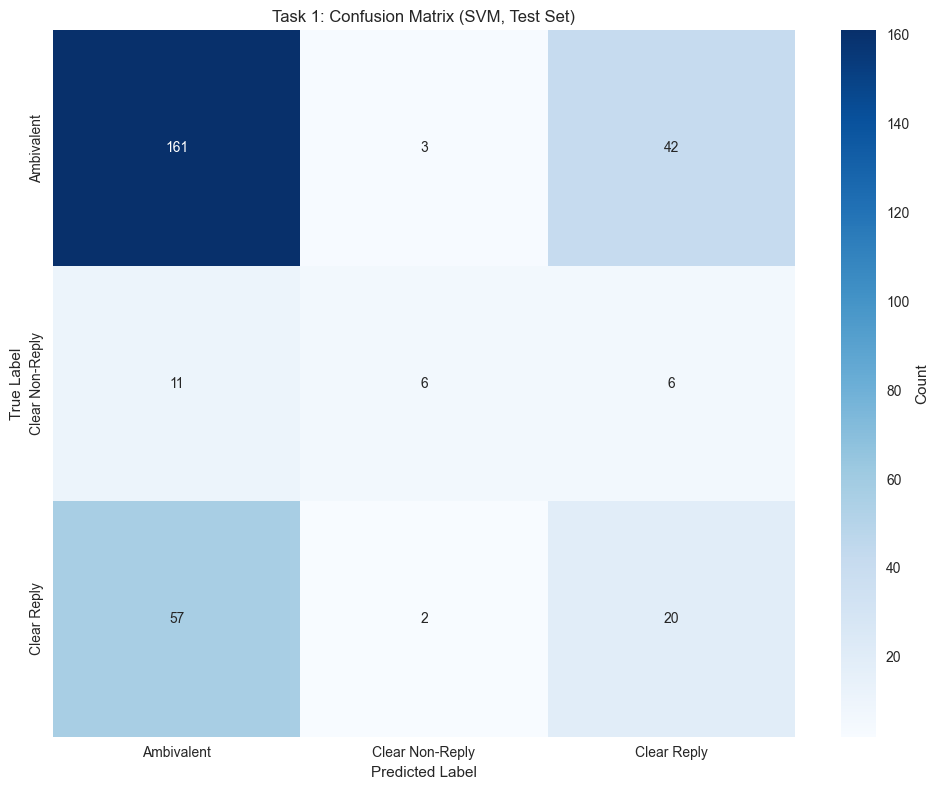

In [ ]:
# Plot confusion matrix for best model on test set
plot_confusion_matrix(
    y_task1_test,
    y_svm_test,
    CLARITY_LABELS,
    title="Task 1: Confusion Matrix (SVM, Test Set)",
    save_path="../report/figures/task1_confusion_matrix.png"
)

### 4.5 Task 1 Results Summary

In [15]:
# Create results table
task1_results = pd.DataFrame([
    {
        'Model': 'Majority',
        'Val Accuracy': maj_metrics_val['accuracy'],
        'Val Macro F1': maj_metrics_val['macro_f1'],
        'Test Accuracy': maj_metrics_test['accuracy'],
        'Test Macro F1': maj_metrics_test['macro_f1']
    },
    {
        'Model': 'Logistic Regression',
        'Val Accuracy': lr_metrics_val['accuracy'],
        'Val Macro F1': lr_metrics_val['macro_f1'],
        'Test Accuracy': lr_metrics_test['accuracy'],
        'Test Macro F1': lr_metrics_test['macro_f1']
    },
    {
        'Model': 'Linear SVM',
        'Val Accuracy': svm_metrics_val['accuracy'],
        'Val Macro F1': svm_metrics_val['macro_f1'],
        'Test Accuracy': svm_metrics_test['accuracy'],
        'Test Macro F1': svm_metrics_test['macro_f1']
    }
])

print("\n" + "="*80)
print("TASK 1: SUMMARY OF RESULTS")
print("="*80)
display(task1_results.round(4))

# Save results
task1_results.to_csv('../report/results/task1_baseline_results.csv', index=False)
print("\nResults saved to ../report/results/task1_baseline_results.csv")


TASK 1: SUMMARY OF RESULTS


,Model,Val Accuracy,Val Macro F1,Test Accuracy,Test Macro F1
0,Majority,0.5913,0.2477,0.6688,0.2672
1,Logistic Regression,0.6203,0.5772,0.5617,0.4462
2,Linear SVM,0.6464,0.5881,0.6071,0.4551



Results saved to ../report/results/task1_baseline_results.csv


## 5. Task 2: Evasion Classification Baselines

### 5.1 Majority Class Baseline

In [16]:
print("BASELINE 1: MAJORITY CLASS")
print("="*60)

# Find majority class
majority_evasion = Counter(y_task2_train).most_common(1)[0][0]
print(f"Majority class: {EVASION_LABELS[majority_evasion]}")

# Validation
y_maj_eva_val = np.full_like(y_task2_val, majority_evasion)
print("\nValidation:")
maj_eva_metrics_val = evaluate_task2_standard(y_task2_val, y_maj_eva_val, EVASION_LABELS)

BASELINE 1: MAJORITY CLASS
Majority class: Explicit

Validation:
TASK 2: EVASION CLASSIFICATION (Single Label)
Accuracy:          0.3043
Macro F1:          0.0519
Weighted F1:       0.1420
Macro Precision:   0.0338
Macro Recall:      0.1111

Classification Report:
                     precision    recall  f1-score   support

   Claims ignorance       0.00      0.00      0.00        12
      Clarification       0.00      0.00      0.00         9
Declining to answer       0.00      0.00      0.00        14
         Deflection       0.00      0.00      0.00        38
            Dodging       0.00      0.00      0.00        71
           Explicit       0.30      1.00      0.47       105
            General       0.00      0.00      0.00        39
           Implicit       0.00      0.00      0.00        49
Partial/half-answer       0.00      0.00      0.00         8

           accuracy                           0.30       345
          macro avg       0.03      0.11      0.05       345
 

### 5.2 Logistic Regression

In [17]:
print("\nBASELINE 2: TF-IDF + LOGISTIC REGRESSION")
print("="*60)

lr_eva_clf = LogisticRegression(
    max_iter=2000,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

print("Training...")
lr_eva_clf.fit(X_task2_train, y_task2_train)

# Validation
y_lr_eva_val = lr_eva_clf.predict(X_task2_val)
print("\nValidation:")
lr_eva_metrics_val = evaluate_task2_standard(y_task2_val, y_lr_eva_val, EVASION_LABELS)


BASELINE 2: TF-IDF + LOGISTIC REGRESSION
Training...


c:\Users\minhn\anaconda3\envs\venv-llm\Lib\site-packages\sklearn\linear_model\_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)



Validation:
TASK 2: EVASION CLASSIFICATION (Single Label)
Accuracy:          0.3014
Macro F1:          0.2968
Weighted F1:       0.3048
Macro Precision:   0.2869
Macro Recall:      0.3253

Classification Report:
                     precision    recall  f1-score   support

   Claims ignorance       0.22      0.33      0.27        12
      Clarification       0.47      0.78      0.58         9
Declining to answer       0.36      0.29      0.32        14
         Deflection       0.20      0.32      0.25        38
            Dodging       0.30      0.30      0.30        71
           Explicit       0.44      0.32      0.37       105
            General       0.24      0.21      0.22        39
           Implicit       0.28      0.27      0.27        49
Partial/half-answer       0.07      0.12      0.09         8

           accuracy                           0.30       345
          macro avg       0.29      0.33      0.30       345
       weighted avg       0.32      0.30      0.30   

### 5.3 Linear SVM

In [18]:
print("\nBASELINE 3: TF-IDF + LINEAR SVM")
print("="*60)

svm_eva_clf = LinearSVC(
    class_weight='balanced',
    random_state=42,
    max_iter=3000
)

print("Training...")
svm_eva_clf.fit(X_task2_train, y_task2_train)

# Validation
y_svm_eva_val = svm_eva_clf.predict(X_task2_val)
print("\nValidation:")
svm_eva_metrics_val = evaluate_task2_standard(y_task2_val, y_svm_eva_val, EVASION_LABELS)


BASELINE 3: TF-IDF + LINEAR SVM
Training...

Validation:
TASK 2: EVASION CLASSIFICATION (Single Label)
Accuracy:          0.3304
Macro F1:          0.3025
Weighted F1:       0.3328
Macro Precision:   0.3102
Macro Recall:      0.3018

Classification Report:
                     precision    recall  f1-score   support

   Claims ignorance       0.20      0.25      0.22        12
      Clarification       0.56      0.56      0.56         9
Declining to answer       0.44      0.29      0.35        14
         Deflection       0.22      0.26      0.24        38
            Dodging       0.37      0.32      0.34        71
           Explicit       0.44      0.45      0.44       105
            General       0.20      0.18      0.19        39
           Implicit       0.30      0.29      0.29        49
Partial/half-answer       0.07      0.12      0.09         8

           accuracy                           0.33       345
          macro avg       0.31      0.30      0.30       345
       w

### 5.4 Test Set Evaluation (Multi-Annotator)

Models are evaluated on validation with accuracy and macro F1, and on test using an “any annotator label is correct” accuracy metric

In [19]:
print("\nEVALUATION ON TEST SET (Multi-Annotator)")
print("="*60)

# Get predictions on test set
y_svm_eva_test_ids = svm_eva_clf.predict(X_task2_test)

# Convert to label strings
y_svm_eva_test_labels = [ID_TO_EVASION[i] for i in y_svm_eva_test_ids]

# Get gold sets from annotators
gold_sets = task2_test['annotator_labels'].tolist()

# Evaluate
test_metrics = evaluate_task2_multi_annotator(
    y_svm_eva_test_labels,
    gold_sets,
    verbose=True
)

# Show some examples
print("\nExample predictions vs annotator labels:")
for i in range(min(5, len(y_svm_eva_test_labels))):
    pred = y_svm_eva_test_labels[i]
    gold = gold_sets[i]
    correct = "✓" if pred in gold else "✗"
    print(f"{correct} Pred: {pred:20s} | Gold: {gold}")


EVALUATION ON TEST SET (Multi-Annotator)
TASK 2: EVASION CLASSIFICATION (Multi-Annotator)
Total examples:    308
Correct:           109
Accuracy:          0.3539

Note: Prediction counted as correct if it matches ANY annotator.

Example predictions vs annotator labels:
✓ Pred: Dodging              | Gold: {'Dodging', 'General'}
✓ Pred: General              | Gold: {'Deflection', 'General'}
✓ Pred: Explicit             | Gold: {'Explicit', 'Implicit'}
✓ Pred: General              | Gold: {'Explicit', 'General'}
✗ Pred: Claims ignorance     | Gold: {'Implicit', 'Dodging'}


### 5.5 Task 2 Results Summary

In [21]:
# Create results table
task2_results = pd.DataFrame([
    {
        'Model': 'Majority',
        'Val Accuracy': maj_eva_metrics_val['accuracy'],
        'Val Macro F1': maj_eva_metrics_val['macro_f1'],
        'Test Accuracy (Any)': None  # N/A for majority baseline
    },
    {
        'Model': 'Logistic Regression',
        'Val Accuracy': lr_eva_metrics_val['accuracy'],
        'Val Macro F1': lr_eva_metrics_val['macro_f1'],
        'Test Accuracy (Any)': None  # Can add if desired
    },
    {
        'Model': 'Linear SVM',
        'Val Accuracy': svm_eva_metrics_val['accuracy'],
        'Val Macro F1': svm_eva_metrics_val['macro_f1'],
        'Test Accuracy (Any)': test_metrics['accuracy_any_annotator']
    }
])

print("\n" + "="*80)
print("TASK 2: SUMMARY OF RESULTS")
print("="*80)
display(task2_results.round(4))

# Save results
task2_results.to_csv('../report/results/task2_baseline_results.csv', index=False)
print("\nResults saved to ../report/results/task2_baseline_results.csv")


TASK 2: SUMMARY OF RESULTS


,Model,Val Accuracy,Val Macro F1,Test Accuracy (Any)
0,Majority,0.3043,0.0519,NaN
1,Logistic Regression,0.3014,0.2968,NaN
2,Linear SVM,0.3304,0.3025,0.3539



Results saved to ../report/results/task2_baseline_results.csv


## 6. Key Findings and Next Steps

In [22]:
print("="*80)
print("KEY FINDINGS")
print("="*80)

print("\n1. TASK 1 (Clarity):")
print(f"   Best Model: Linear SVM")
print(f"   Test Accuracy: {svm_metrics_test['accuracy']:.4f}")
print(f"   Test Macro F1: {svm_metrics_test['macro_f1']:.4f}")

print("\n2. TASK 2 (Evasion):")
print(f"   Best Model: Linear SVM")
print(f"   Val Accuracy: {svm_eva_metrics_val['accuracy']:.4f}")
print(f"   Val Macro F1: {svm_eva_metrics_val['macro_f1']:.4f}")
print(f"   Test Accuracy (Any Annotator): {test_metrics['accuracy_any_annotator']:.4f}")

print("\n3. OBSERVATIONS:")
print("   - Task 1 is significantly easier than Task 2")
print("   - Class imbalance affects Task 2 performance")
print("   - TF-IDF captures lexical patterns reasonably well")
print("   - Transformer models should improve on these baselines")

print("\n4. NEXT STEPS:")
print("   - Implement transformer baselines (BERT, RoBERTa)")
print("   - Try ensemble methods")
print("   - Analyze error cases")
print("   - Consider multi-task learning approach")

KEY FINDINGS

1. TASK 1 (Clarity):
   Best Model: Linear SVM
   Test Accuracy: 0.6071
   Test Macro F1: 0.4551

2. TASK 2 (Evasion):
   Best Model: Linear SVM
   Val Accuracy: 0.3304
   Val Macro F1: 0.3025
   Test Accuracy (Any Annotator): 0.3539

3. OBSERVATIONS:
   - Task 1 is significantly easier than Task 2
   - Class imbalance affects Task 2 performance
   - TF-IDF captures lexical patterns reasonably well
   - Transformer models should improve on these baselines

4. NEXT STEPS:
   - Implement transformer baselines (BERT, RoBERTa)
   - Try ensemble methods
   - Analyze error cases
   - Consider multi-task learning approach


## 7. Save Models for Future Use

In [23]:
import pickle

# Create models directory
models_dir = Path('../models')
models_dir.mkdir(exist_ok=True)

# Save TF-IDF vectorizer
with open(models_dir / 'tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf, f)

# Save best models
with open(models_dir / 'task1_svm.pkl', 'wb') as f:
    pickle.dump(svm_clf, f)
    
with open(models_dir / 'task2_svm.pkl', 'wb') as f:
    pickle.dump(svm_eva_clf, f)

print("Models saved to ../models/")

Models saved to ../models/
